In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [77]:
# From https://github.com/microhh/microhh/blob/9c3b9f27b47d174c05386e24a7878ee3444ce0b9/python/microhh_to_raytracer_input.py#L83
def calc_sun_distance_factor(day_of_year, seconds_since_midnight):
    # Based on: An Introduction to Atmospheric Radiation, Liou, Eq. 2.2.9.
    an = [1.000110, 0.034221, 0.000719]
    bn = [0,        0.001280, 0.000077]
    frac_doy = day_of_year + seconds_since_midnight / 86400.
    t = 2. * np.pi*(frac_doy - 1.)/ 365.

    factor = 0.
    for n in range(3):
        factor += an[n]*np.cos(n*t) + bn[n]*np.sin(n*t);

    return factor

constZenith, lat 7.5 angle: 71.28853974396148
swin from zenith calculation 423.6376149156913
swin from RRTMG 416.6942
constZenith, lat 12.5 angle: 70.75084934413448
swin from zenith calculation 435.356501212123
swin from RRTMG 428.2607


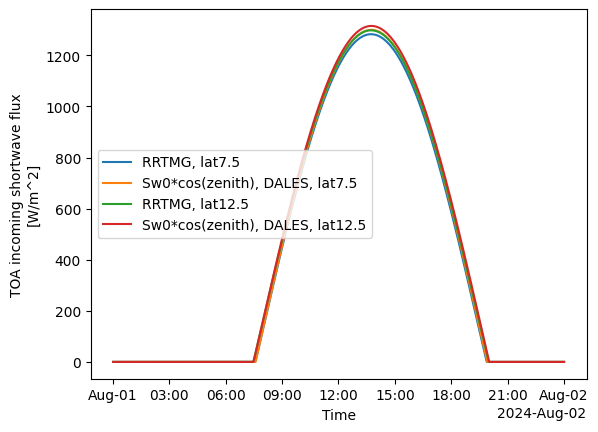

In [81]:
# For these times, calculate the zenith angle from DALES
xlat = [7.5, 12.5]
xlon = 334
xyear = 2024
xday = 214
sw0 = 1.360822e+03

data_path = ['../../../fredrik/deep-botany/ensemble-2/run_1',
             '../../../fredrik/deep-botany/ensemble-2/run_2']

tmin = '2024-08-01 00:00:00'
tmax = '2024-08-02 00:00:00'

for i in range(len(data_path)):
    swinex = xr.open_dataset(data_path[i]+'/tmser.001.nc')['rsdt'].sel(time=slice(tmin,tmax))
    
    time = (swinex['time'] - swinex['time'][0]).dt.total_seconds()
    
    day    = xday
    daytime= time%86400.
    
    phi    = xlat[i] * np.pi/180.
    el     = xlon * np.pi/180.
    obliq  = 23.45 * np.pi/180.
    xlam   = 4.88 + 0.0172 * day
    declin = np.arcsin(np.sin(obliq)*np.sin(xlam)) # Check that this returns the right angle
    hora   = el-np.pi + 2.*np.pi*(daytime/86400.)
    zenith = np.maximum(0.,np.sin(declin)*np.sin(phi)+np.cos(declin)*np.cos(phi)*np.cos(hora))
    # This is the cosine of the zenith angle

    # Calculate the zenith angle that gives you mean(cos(zenith))
    constZenith = (np.arccos(np.mean(zenith))*180/np.pi).data
    print('constZenith, lat', xlat[i], 'angle:' , constZenith)

    # sun-earth distance scaling through the year, sssuming roughly constant over a day
    tsi_scaling = np.mean(calc_sun_distance_factor(xday, time.to_numpy()))

    # Daily averaged swin is then:
    print('swin from zenith calculation', np.cos(constZenith*np.pi/180.)*sw0*tsi_scaling)
    print('swin from RRTMG', swinex.mean().data)

    swinex.plot(x='time', label='RRTMG, lat'+str(xlat[i]))
    plt.plot(swinex.time,sw0*zenith*tsi_scaling, label='Sw0*cos(zenith), DALES, lat'+str(xlat[i]))
plt.legend()
plt.savefig('data/figures/zenith.pdf', bbox_inches='tight')